# WHAT DRIVES THE PRICE OF A CAR?




**OVERVIEW**

In this application, a dataset from Kaggle will be explored. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing. The goal is to understand what factors make a car more or less expensive.  As a result of the analysis, clear recommendations to your the client -- a used car dealership -- will be provided as to what consumers value in a used car.

### CRISP-DM Framework

<left>
    <img src = images/crisp-dm.png width = 25%/>
</left>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  

### Business Understanding

A used car dealership client would like to identify key drivers for used car prices. What do consumers value the most in a used car before making the decision to buy? What clear recommendations can we provide in order for the dealership profit in selling their used cars?

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Some of the steps we are taking to get to know the data are the following:
    - Look into numerical and categorical variableŵ
    - Check what kind of features are available
    - Delete records with Nans and make sure there are no missing price 
    - Build histogram to see the distribution of price

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [8]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import os
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [9]:
# import data
usedcars_df = pd.read_csv('data/vehicles.csv')
usedcars_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [10]:
# drop records with missing values (NaN)
usedcars_df_cleaned = usedcars_df.dropna()
usedcars_df_cleaned.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al


In [11]:
# Delete irrelevant columns
usedcars_df_cleaned = usedcars_df_cleaned.drop(columns=['id', 'region', 'drive','VIN', 'model', 'size','paint_color'])
usedcars_df_cleaned.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,type,state
126,0,2018.0,chevrolet,like new,6 cylinders,gas,68472.0,clean,automatic,van,al
127,0,2019.0,chevrolet,like new,6 cylinders,gas,69125.0,clean,automatic,van,al
128,0,2018.0,chevrolet,like new,6 cylinders,gas,66555.0,clean,automatic,van,al
215,4000,2002.0,toyota,excellent,4 cylinders,gas,155000.0,clean,automatic,sedan,al
219,2500,1995.0,bmw,fair,6 cylinders,gas,110661.0,clean,automatic,sedan,al


In [12]:
# Delete decimal point from year and odometer columns
usedcars_df_cleaned['year'] = usedcars_df_cleaned['year'].astype(int)
usedcars_df_cleaned['odometer'] = usedcars_df_cleaned['odometer'].astype(int)
usedcars_df_cleaned.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,type,state
126,0,2018,chevrolet,like new,6 cylinders,gas,68472,clean,automatic,van,al
127,0,2019,chevrolet,like new,6 cylinders,gas,69125,clean,automatic,van,al
128,0,2018,chevrolet,like new,6 cylinders,gas,66555,clean,automatic,van,al
215,4000,2002,toyota,excellent,4 cylinders,gas,155000,clean,automatic,sedan,al
219,2500,1995,bmw,fair,6 cylinders,gas,110661,clean,automatic,sedan,al


In [13]:
# Figure out columns with 0 entries and count the records in those columns that have zeros

zero_values = (usedcars_df_cleaned == 0).sum()
zero_values = zero_values[zero_values > 0]  

print(zero_values)

price       2372
odometer      81
dtype: int64


In [14]:
# Determine the % of records without price
zero_values_pct = zero_values / len(usedcars_df_cleaned)
zero_values_pct

price       0.068028
odometer    0.002323
dtype: float64

#### Since the % of these missing records are not too significant, decided to delete them. 

In [16]:
# Remove records with zero prices 
usedcars_df_cleaned = usedcars_df_cleaned[usedcars_df_cleaned['price'] != 0]
usedcars_df_cleaned.head()

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,type,state
215,4000,2002,toyota,excellent,4 cylinders,gas,155000,clean,automatic,sedan,al
219,2500,1995,bmw,fair,6 cylinders,gas,110661,clean,automatic,sedan,al
268,9000,2008,mazda,excellent,4 cylinders,gas,56700,clean,automatic,convertible,al
337,8950,2011,ford,excellent,6 cylinders,gas,164000,clean,automatic,truck,al
338,4000,1972,mercedes-benz,fair,6 cylinders,gas,88100,clean,automatic,coupe,al


In [17]:
# Separating numerical and categorical values for the relevant columns
category_vars = usedcars_df_cleaned.columns[usedcars_df_cleaned.dtypes == 'object'].tolist()
numeric_vars = usedcars_df_cleaned.columns[usedcars_df_cleaned.dtypes != 'object'].tolist()

print(category_vars)
print(numeric_vars)

['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'type', 'state']
['price', 'year', 'odometer']


In [18]:
print("The data has {} rows and {} columns".format(usedcars_df_cleaned.shape[0], usedcars_df_cleaned.shape[1]))
display(usedcars_df_cleaned.describe())
display(usedcars_df_cleaned.dtypes.value_counts())

The data has 32496 rows and 11 columns


,price,year,odometer
count,32496.000000,32496.000000,3.249600e+04
mean,16993.479013,2010.938269,1.089832e+05
std,13219.394890,7.274987,1.022710e+05
min,1.000000,1905.000000,0.000000e+00
25%,7500.000000,2008.000000,6.744975e+04
50%,13125.500000,2012.000000,1.055840e+05
75%,23395.000000,2015.000000,1.428455e+05
max,155000.000000,2022.000000,9.999999e+06


object    8
int64     3
dtype: int64

#### The minimum price and odometer show $1 and 0 which doesn't make sense. Look into outliers in the data

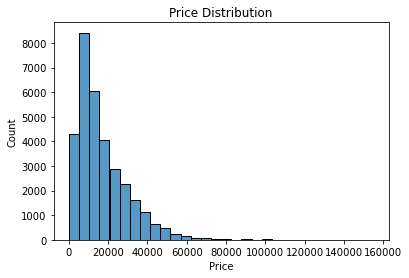

In [20]:
# Visualize price distribution
sns.histplot(data=usedcars_df_cleaned, x='price', bins=30)

plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')

plt.savefig('images/price_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

In [21]:
# Calculate quartiles and outliers for price
Q1 = usedcars_df_cleaned['price'].quantile(0.25)
Q3 = usedcars_df_cleaned['price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = usedcars_df_cleaned[(usedcars_df_cleaned['price'] < lower_bound) | (usedcars_df_cleaned['price'] > upper_bound)]
num_outliers = usedcars_df_cleaned[(usedcars_df_cleaned['price'] < lower_bound) | (usedcars_df_cleaned['price'] > upper_bound)].shape[0]

print(f"First Quartile: {Q1}")
print(f"Third Quartile: {Q3}")
print(f"Lower Bound: {lower_bound}")
print(f"Upper Bound: {upper_bound}")
print(f"Number of outliers in price: {num_outliers}")


First Quartile: 7500.0
Third Quartile: 23395.0
Lower Bound: -16342.5
Upper Bound: 47237.5
Number of outliers in price: 1007


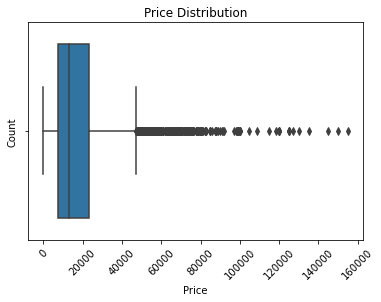

In [22]:
# Visualize outlier for price
sns.boxplot(data=usedcars_df_cleaned, x='price')

plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

plt.savefig('images/price_dist_boxplot.png', dpi=300, bbox_inches='tight')

plt.show()


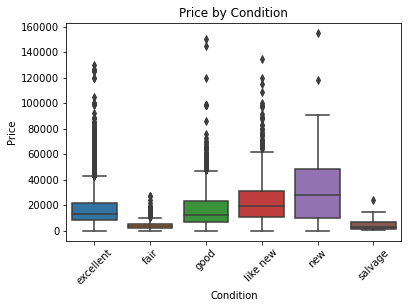

In [23]:
# Visualize outliers by condition
sns.boxplot(data=usedcars_df_cleaned, x='condition', y='price')

plt.title('Price by Condition')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

plt.savefig('images/price_bycondition.png', dpi=300, bbox_inches='tight')

plt.show()

In [24]:
# Create a new df without outliers (based on price)
df_no_outl = usedcars_df_cleaned[(usedcars_df_cleaned['price'] >= lower_bound) & (usedcars_df_cleaned['price'] <= upper_bound)]
df_no_outl

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,type,state
215,4000,2002,toyota,excellent,4 cylinders,gas,155000,clean,automatic,sedan,al
219,2500,1995,bmw,fair,6 cylinders,gas,110661,clean,automatic,sedan,al
268,9000,2008,mazda,excellent,4 cylinders,gas,56700,clean,automatic,convertible,al
337,8950,2011,ford,excellent,6 cylinders,gas,164000,clean,automatic,truck,al
338,4000,1972,mercedes-benz,fair,6 cylinders,gas,88100,clean,automatic,coupe,al
...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015,ford,like new,8 cylinders,gas,146795,clean,automatic,truck,wy
426788,12995,2016,chevrolet,like new,4 cylinders,gas,61127,clean,automatic,sedan,wy
426792,32999,2014,ford,excellent,8 cylinders,diesel,154642,clean,automatic,pickup,wy
426793,15999,2018,chevrolet,excellent,4 cylinders,gas,36465,clean,automatic,sedan,wy


In [25]:
# Summary stats for data without outliers
df_no_outl.describe()

,price,year,odometer
count,31489.000000,31489.000000,3.148900e+04
mean,15643.605005,2010.793071,1.109117e+05
std,10734.321866,7.159203,1.030573e+05
min,1.000000,1905.000000,0.000000e+00
25%,7450.000000,2008.000000,7.020000e+04
50%,12990.000000,2012.000000,1.073450e+05
75%,21995.000000,2015.000000,1.440000e+05
max,47100.000000,2022.000000,9.999999e+06


#### For modelling purposes, limit the price included in the data to a more reasonable price. Per my research, a reasonable price for a used car in US market should be no less than 2,000. Anything less than that often have serious mechanical issues, may not pass inspections, may have some repairs needed but will cost more to repair than own, salvaged or even scams.
#### For maximum price, anything above $100K is an outlier unless it is a luxury car.

In [27]:
# Create a new df to be used in modeling limiting only used cars from 2k through 100k
model_df = df_no_outl[(df_no_outl['price'] >= 2_000) & (df_no_outl['price'] < 100_000)]
model_df

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,type,state
215,4000,2002,toyota,excellent,4 cylinders,gas,155000,clean,automatic,sedan,al
219,2500,1995,bmw,fair,6 cylinders,gas,110661,clean,automatic,sedan,al
268,9000,2008,mazda,excellent,4 cylinders,gas,56700,clean,automatic,convertible,al
337,8950,2011,ford,excellent,6 cylinders,gas,164000,clean,automatic,truck,al
338,4000,1972,mercedes-benz,fair,6 cylinders,gas,88100,clean,automatic,coupe,al
...,...,...,...,...,...,...,...,...,...,...,...
426785,23495,2015,ford,like new,8 cylinders,gas,146795,clean,automatic,truck,wy
426788,12995,2016,chevrolet,like new,4 cylinders,gas,61127,clean,automatic,sedan,wy
426792,32999,2014,ford,excellent,8 cylinders,diesel,154642,clean,automatic,pickup,wy
426793,15999,2018,chevrolet,excellent,4 cylinders,gas,36465,clean,automatic,sedan,wy


In [28]:
model_df.describe()

,price,year,odometer
count,30330.000000,30330.000000,3.033000e+04
mean,16224.406264,2010.761919,1.112031e+05
std,10509.384724,7.141172,8.570338e+04
min,2000.000000,1905.000000,0.000000e+00
25%,7990.000000,2008.000000,7.200000e+04
50%,13488.000000,2012.000000,1.083010e+05
75%,22600.000000,2015.000000,1.443218e+05
max,47100.000000,2022.000000,9.999999e+06


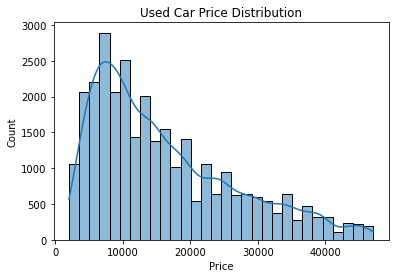

In [29]:
sns.histplot(data=model_df, x='price', bins=30, kde=True)

plt.title('Used Car Price Distribution')
plt.xlabel('Price')
plt.ylabel('Count')

plt.savefig('images/model_price_distr.png', dpi=300, bbox_inches='tight')

plt.show()

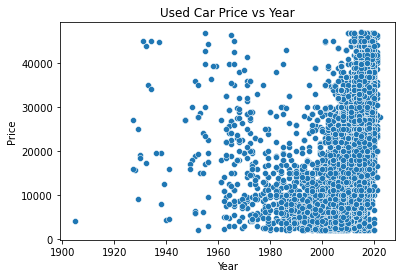

In [30]:
sns.scatterplot(data=model_df, x='year', y='price')

plt.title('Used Car Price vs Year')
plt.xlabel('Year')
plt.ylabel('Price')

plt.savefig('images/price_by_year.png', dpi=300, bbox_inches='tight')

plt.show()

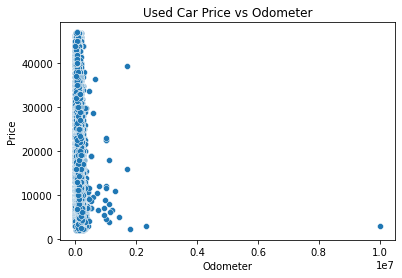

In [31]:
sns.scatterplot(data=model_df, x='odometer', y='price')

plt.title('Used Car Price vs Odometer')
plt.xlabel('Odometer')
plt.ylabel('Price')

plt.savefig('images/price_by_odometer.png', dpi=300, bbox_inches='tight')

plt.show()

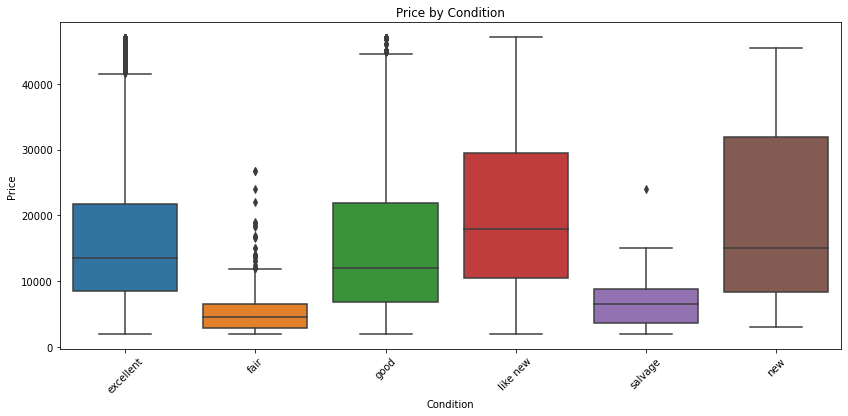

In [32]:
# Visualize the updated chart for condition vs price
plt.figure(figsize=(14, 6))
sns.boxplot(data=model_df, x='condition', y='price')

plt.title('Price by Condition')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed

plt.savefig('images/price_bycond_model.png', dpi=300, bbox_inches='tight')

plt.show()

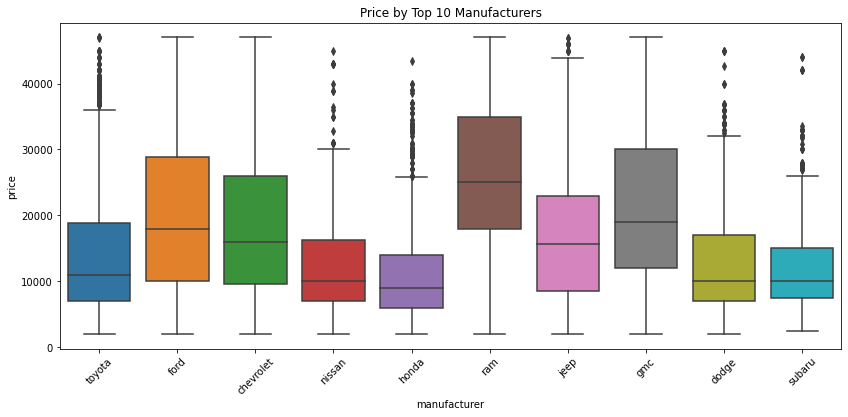

In [33]:
# Visualize top 10  manufacturers
plt.figure(figsize=(14, 6))
top_mfr = model_df['manufacturer'].value_counts().nlargest(10).index
sns.boxplot(x='manufacturer', y='price', data=model_df[model_df['manufacturer'].isin(top_mfr)])
plt.title('Price by Top 10 Manufacturers')
plt.xticks(rotation=45)

plt.savefig('images/price_bymanuf.png', dpi=300, bbox_inches='tight')

plt.show()

#### Observations: a.) most recent cars are more expensive than older ones, b.) used cars with less mileage are more expensive, c.) new and like new are definitely more expensive and d.) manufacturer affects the price significantly (brands like toyota, honda and nissan are less expensive compared to ram, gmc and ford); most likely because some of these brands also are suvs and trucks which are definitely more pricey. 

In [35]:
# Find correlation between numerical variables

model_df.corr()

,price,year,odometer
price,1.000000,0.363003,-0.278573
year,0.363003,1.000000,-0.217413
odometer,-0.278573,-0.217413,1.000000


#### The relationship between the numerical features are weak based on this correlation matrix

In [37]:
#Split dependent and independent variables 

X = model_df.drop(['price'], axis=1)
y = model_df['price']
X

,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,type,state
215,2002,toyota,excellent,4 cylinders,gas,155000,clean,automatic,sedan,al
219,1995,bmw,fair,6 cylinders,gas,110661,clean,automatic,sedan,al
268,2008,mazda,excellent,4 cylinders,gas,56700,clean,automatic,convertible,al
337,2011,ford,excellent,6 cylinders,gas,164000,clean,automatic,truck,al
338,1972,mercedes-benz,fair,6 cylinders,gas,88100,clean,automatic,coupe,al
...,...,...,...,...,...,...,...,...,...,...
426785,2015,ford,like new,8 cylinders,gas,146795,clean,automatic,truck,wy
426788,2016,chevrolet,like new,4 cylinders,gas,61127,clean,automatic,sedan,wy
426792,2014,ford,excellent,8 cylinders,diesel,154642,clean,automatic,pickup,wy
426793,2018,chevrolet,excellent,4 cylinders,gas,36465,clean,automatic,sedan,wy


In [38]:
# Separate categorical variables in X
cat_vars = X.loc[:, category_vars]
cat_vars

,manufacturer,condition,cylinders,fuel,title_status,transmission,type,state
215,toyota,excellent,4 cylinders,gas,clean,automatic,sedan,al
219,bmw,fair,6 cylinders,gas,clean,automatic,sedan,al
268,mazda,excellent,4 cylinders,gas,clean,automatic,convertible,al
337,ford,excellent,6 cylinders,gas,clean,automatic,truck,al
338,mercedes-benz,fair,6 cylinders,gas,clean,automatic,coupe,al
...,...,...,...,...,...,...,...,...
426785,ford,like new,8 cylinders,gas,clean,automatic,truck,wy
426788,chevrolet,like new,4 cylinders,gas,clean,automatic,sedan,wy
426792,ford,excellent,8 cylinders,diesel,clean,automatic,pickup,wy
426793,chevrolet,excellent,4 cylinders,gas,clean,automatic,sedan,wy


In [39]:
# One hot encoding of categorical variables
usedcar_dummies = pd.get_dummies(cat_vars, drop_first=True, prefix='', prefix_sep='')
usedcar_dummies

,alfa-romeo,aston-martin,audi,bmw,buick,cadillac,chevrolet,chrysler,datsun,dodge,...,sd,tn,tx,ut,va,vt,wa,wi,wv,wy
215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
338,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
426788,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
426792,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
426793,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [67]:
# Drop the categorical columns to avoid redundancy. Also will not be able to fit X when these categorical columns exist

X = X.drop(list(cat_vars.columns), axis=1)
X

,year,odometer
215,2002,155000
219,1995,110661
268,2008,56700
337,2011,164000
338,1972,88100
...,...,...
426785,2015,146795
426788,2016,61127
426792,2014,154642
426793,2018,36465


In [69]:
# Concatenate numerical and converted dummies

X = pd.concat([X, usedcar_dummies], axis=1)
X

,year,odometer,alfa-romeo,aston-martin,audi,bmw,buick,cadillac,chevrolet,chrysler,...,sd,tn,tx,ut,va,vt,wa,wi,wv,wy
215,2002,155000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
219,1995,110661,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
268,2008,56700,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
337,2011,164000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
338,1972,88100,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,2015,146795,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
426788,2016,61127,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
426792,2014,154642,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
426793,2018,36465,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [71]:
# Scale the data with Standard Scaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the scaler on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Apply the same transformation to test data
X_test_scaled = scaler.transform(X_test)

### MODELING AND EVALUATION

#### MODEL 1:  Linear Regression

In [73]:
#Instantiate and fit linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression()

In [75]:
print(linreg.coef_)
print(linreg.intercept_)

[ 5.52846432e+02 -2.57533145e-02  7.14438485e+03  2.09023378e+04
  2.19756358e+03  9.70994833e+02 -2.90895999e+02  6.79793209e+02
 -4.74518418e+02 -3.20872585e+03  2.05325519e+04 -2.44269045e+03
  3.10517397e+04 -7.27700271e+03 -6.71320898e+02  7.24563496e+01
 -1.05001980e+04 -8.96894458e+02 -2.47143043e+03  1.07998350e+03
 -6.99599377e+02  7.78440960e+02 -2.84944743e+03 -6.66111827e+03
  1.71243281e+03 -5.12388899e+02 -1.31855559e+03  1.92389164e+03
 -2.74044992e+03 -2.87882845e+03  1.53066995e+02 -2.78255549e+03
 -6.53148612e+01  6.58134125e+03  6.86748631e+02  3.83250411e+03
 -4.80392168e+03 -5.07918833e+01  2.18004624e+04  7.92280381e+02
 -1.37837761e+03  3.97935267e+02 -3.75670559e+03 -1.78666406e+03
  2.28789604e+03  3.89321397e+03 -5.09253498e+03 -6.36711634e+03
 -8.79240299e+03 -8.79774612e+03 -9.99810627e+03 -5.84048455e+03
 -2.72203819e+03 -7.19091591e+03 -1.07015492e+04 -9.24911788e+03
 -8.89244098e+03 -1.11068871e+04  1.61292427e+03  9.28904113e+03
 -6.60341520e+03 -1.03975

#### Looks like many features are either positive or negatively correlated

In [82]:

y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Define evaluation metrics (To  be used in all models)
eval_metrics = {
    'R2 Train': r2_score(y_train, y_train_pred),
    'R2 Test': r2_score(y_test, y_test_pred),
    'MSE Train': mean_squared_error(y_train, y_train_pred),
    'MSE Test': mean_squared_error(y_test, y_test_pred)
}

# Print metrics
m1_eval_metrics = []
for name, value in eval_metrics.items():
    print(f"{name}: {value:.4f}")
    m1_eval_metrics.append(value)

R2 Train: 0.5955
R2 Test: 0.5938
MSE Train: 44655389.4554
MSE Test: 44931963.9745


#### Evaluation of Linear Regression model

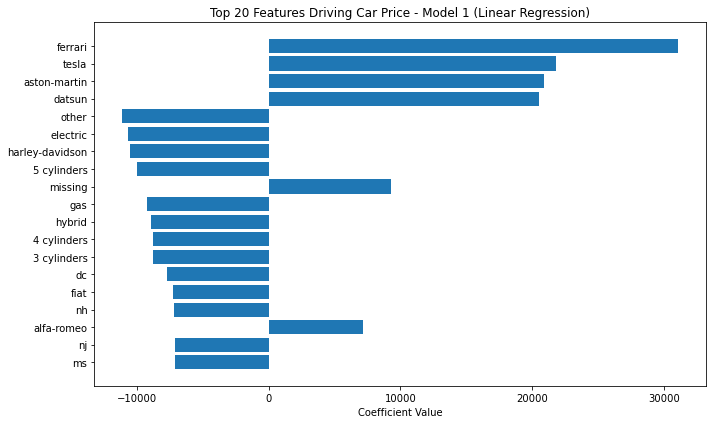

,Feature,Importance
12,ferrari,31051.739663


In [85]:
featimp_linreg_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': linreg.coef_
}).sort_values(by='Importance', key=abs, ascending=False)

# Plot top 20 features
top20_feat_linreg = featimp_linreg_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top20_feat_linreg['Feature'], top20_feat_linreg['Importance'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Features Driving Car Price - Model 1 (Linear Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('images/linreg_features.png', dpi=300, bbox_inches='tight')

plt.show()

top20_feat_linreg.head(1)  # Return most important feature

### Model 2: Ridge Regression

In [87]:
# Instantiate and fit ridge regression and start with 5 values of alpha (for penalty term)

alphas = [0.01, 0.1, 1, 10, 100]  
param_grid = {'alpha': alphas}

ridge = Ridge()
grid = GridSearchCV(ridge, param_grid, cv=5, return_train_score=True, verbose=1)
grid.fit(X_train, y_train)

print("Best alpha:", grid.best_params_['alpha'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/Users/katmatovic/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=5.65911e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Best alpha: 0.01


In [89]:
#Fitting ridge model for alpha = 0.01
alpha = 0.01
best_ridge = Ridge(alpha=alpha)

best_ridge.fit(X_train, y_train)
print(best_ridge.coef_)

[ 5.52839280e+02 -2.57541378e-02  7.13445904e+03  2.06907455e+04
  2.19398003e+03  9.67368119e+02 -2.94592240e+02  6.76235270e+02
 -4.78107869e+02 -3.21229320e+03  2.04249661e+04 -2.44612503e+03
  3.07389496e+04 -7.27745778e+03 -6.74823258e+02  6.89133413e+01
 -1.04771625e+04 -9.00596851e+02 -2.47491930e+03  1.07634261e+03
 -7.03472613e+02  7.74977031e+02 -2.85301717e+03 -6.59774594e+03
  1.70903724e+03 -5.16140729e+02 -1.32225442e+03  1.92018761e+03
 -2.74369108e+03 -2.88205909e+03  1.49367077e+02 -2.78620979e+03
 -6.91402151e+01  6.57644696e+03  6.83366665e+02  3.82853219e+03
 -4.80710383e+03 -5.43898921e+01  2.17581336e+04  7.88704019e+02
 -1.38196704e+03  3.94078889e+02 -3.75637469e+03 -1.78677762e+03
  2.28799466e+03  3.89253251e+03 -5.08998085e+03 -6.35579934e+03
 -8.78836861e+03 -8.79536120e+03 -9.99529514e+03 -5.83813975e+03
 -2.71974032e+03 -7.18719899e+03 -1.06948344e+04 -9.24861998e+03
 -8.89157362e+03 -1.11017048e+04  1.61296710e+03  9.27766061e+03
 -6.53792538e+03 -1.03961

In [91]:
# Evaluation metrics for model 2
y_train_pred = best_ridge.predict(X_train)
y_test_pred = best_ridge.predict(X_test)

# Print metrics
m2_eval_metrics = []
for name, value in eval_metrics.items():
    print(f"{name}: {value:.4f}")
    m2_eval_metrics.append(value)


R2 Train: 0.5955
R2 Test: 0.5938
MSE Train: 44655389.4554
MSE Test: 44931963.9745


#### Evaluation of Model 2 - Ridge Regression

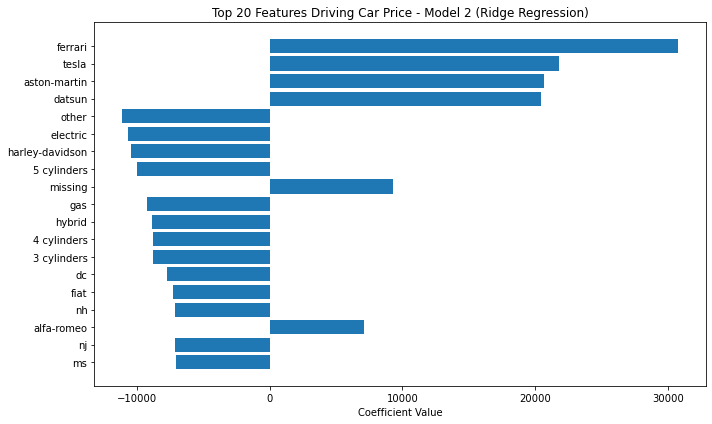

,Feature,Importance
12,ferrari,30738.949617


In [94]:
featimp_ridge_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_ridge.coef_
}).sort_values(by='Importance', key=abs, ascending=False)

# Plot top 20 features
top20_feat_ridge = featimp_ridge_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top20_feat_ridge['Feature'], top20_feat_ridge['Importance'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Features Driving Car Price - Model 2 (Ridge Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('images/ridge_features.png', dpi=300, bbox_inches='tight')

plt.show()

top20_feat_ridge.head(1)  # Return most important feature

#### MODEL 3: Lasso Regression

In [97]:
# Instantiate and fit Lasso

lasso = Lasso()

# cross validation
lasso_grid = GridSearchCV(lasso, param_grid, cv=5, return_train_score=True, verbose=1)
lasso_grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 1, 10, 100]},
             return_train_score=True, verbose=1)

In [99]:
model3_lr = linear_model.LinearRegression(fit_intercept=False)
model3_lr.fit(condition_dummies, price)

NameError: name 'condition_dummies' is not defined

In [ ]:
model3_lr.coef_

In [ ]:
mean_squared_error(usedcarsdf_no_outliers['price'], model3_lr.predict(condition_dummies))

In [ ]:
mean_absolute_error(usedcarsdf_no_outliers['price'], model3_lr.predict(condition_dummies))

In [101]:
print("Best alpha:", lasso_grid.best_params_['alpha'])

Best alpha: 0.01


In [103]:
alpha = 0.01
best_lasso = Lasso(alpha=alpha)
best_lasso.fit(X_train, y_train)

print(best_lasso.coef_)

[ 5.52858485e+02 -2.57557767e-02  7.12564632e+03  2.06615263e+04
  2.19937470e+03  9.73247239e+02 -2.88302996e+02  6.81581950e+02
 -4.72021572e+02 -3.20558253e+03  2.04115825e+04 -2.43957557e+03
  3.08106736e+04 -7.26195043e+03 -6.68671617e+02  7.45954763e+01
 -1.04240672e+04 -8.94809506e+02 -2.46850110e+03  1.08055647e+03
 -6.94146524e+02  7.80894631e+02 -2.84662662e+03 -6.41288120e+03
  1.71507165e+03 -5.09277881e+02 -1.31578689e+03  1.92574983e+03
 -2.73435432e+03 -2.87371849e+03  1.54137782e+02 -2.78016553e+03
 -6.14630644e+01  6.58021186e+03  6.89539377e+02  3.83218209e+03
 -4.79851666e+03 -4.81780318e+01  2.17570002e+04  7.94644850e+02
 -1.37544587e+03  3.98142249e+02 -3.75574290e+03 -1.78690818e+03
  2.28849934e+03  3.88966409e+03 -5.07850518e+03 -6.32479034e+03
 -8.77952103e+03 -8.78968734e+03 -9.98863396e+03 -5.83222440e+03
 -2.71407915e+03 -7.17922265e+03 -1.06926218e+04 -9.24777749e+03
 -8.89028874e+03 -1.10959376e+04  1.60983127e+03  9.26104409e+03
 -6.36105111e+03 -1.03870

In [105]:
# Evaluation metrics for model 3

# Predict on train and test set
y_train_pred = best_lasso.predict(X_train)
y_test_pred = best_lasso.predict(X_test)

# Print metrics
m3_eval_metrics = []
for name, value in eval_metrics.items():
    print(f"{name}: {value:.4f}")
    m3_eval_metrics.append(value)


R2 Train: 0.5955
R2 Test: 0.5938
MSE Train: 44655389.4554
MSE Test: 44931963.9745


#### Evaluation of Lasso model

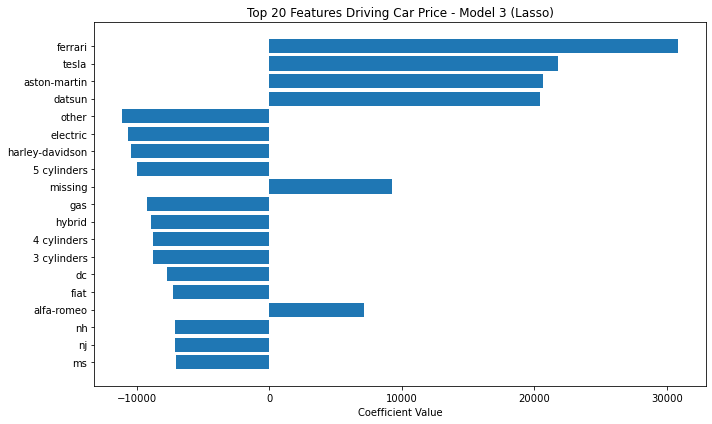

,Feature,Importance
12,ferrari,30810.673621


In [108]:
featimp_lasso_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_lasso.coef_
}).sort_values(by='Importance', key=abs, ascending=False)

# Plot top 20 features
top20_feat_lasso = featimp_lasso_df.head(20)
plt.figure(figsize=(10, 6))
plt.barh(top20_feat_lasso['Feature'], top20_feat_lasso['Importance'])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Features Driving Car Price - Model 3 (Lasso)')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.savefig('images/lasso_features.png', dpi=300, bbox_inches='tight')

plt.show()

top20_feat_lasso.head(1)  # Return most important feature

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.